# Plot NO3 concentration

In [3]:
import os
import xarray
import openpyxl
import contextily as cx 
import yaml
import numpy as np
import pandas
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
root_dir=pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/SOG_NB/")
# surface min salinity and max NO3, water column minimum DO
model_var = ["NO3", "DOXG","salinity"]
stat_type=["mean","min","mean"]
loc=["surface","wc","surface"]
run = "wqm_baseline"

# Load config file
with open('../etc/SSM_config.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']
    
# Loast shapefile 
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

param_plot={}
for idx,var in enumerate(model_var):
    print(f"loading {var}")
    if loc[idx]=='surface':
        run_file = root_dir/var/run/"surface"/f"daily_{stat_type[idx]}_{var}_surface.nc"
        with xarray.open_dataset(run_file) as ds:
            print([*ds][0])
            param_full=ds[[*ds][0]]
            # Sub-sample nodes (from 16012 nodes to 7494)
            param_plot[var]=param_full[:,gdf['node_id']-1]
    else:
        run_file = root_dir/var/run/f"daily_{stat_type[idx]}_{var}.nc"
        with xarray.open_dataset(run_file) as ds:
            print([*ds][0])
            param_full=ds[[*ds][0]]
            # Sub-sample nodes (from 16012 nodes to 7494)
            param=param_full[:,:,gdf['node_id']-1]
            # Apply "stat_type" across depth levels
            param_plot[var] = getattr(np,stat_type[idx])(param,axis=1)
    

loading NO3
NO3_daily_mean_surface
loading DOXG
DOXG_daily_min
loading salinity
salinity_daily_mean_surface


In [6]:
param_plot["salinity"].max().item()

31.895353317260742

### Plot results

In [3]:
day=200
# set all values over 7 to the maximum DO concentration
max_idx=(param_plot["DOXG"][day,:]>7)
param_plot["DOXG"][day,max_idx]=param_plot["DOXG"].max().item()
min_idx=(param_plot["DOXG"][day,:]<2)
param_plot["DOXG"][day,min_idx]=0

nope


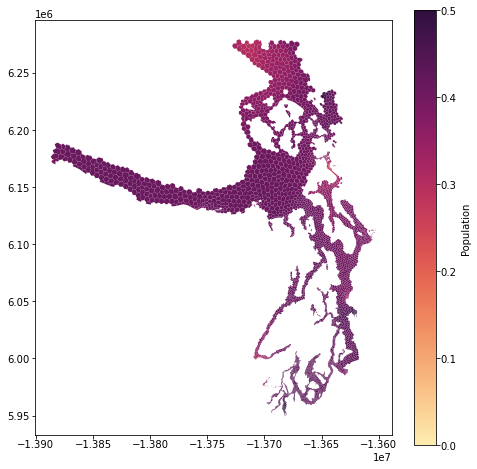

In [18]:
day = 360
# plot salinity with "haline"
import cmocean.cm as cm
gdf["NO3"]=param_plot["NO3"][day,:]
fig, axs = plt.subplots(1, figsize = (8,8))
gdf.plot(ax=axs,
    column="NO3", 
    legend=True,
    legend_kwds={'label': 'Population'},
    cmap=cm.matter,
    vmin=0,
    vmax=0.5
)
legend = axs.get_legend()
if legend != None:
    print('none')
else:
    print('nope')


In [8]:
legend.set_title('test')

AttributeError: 'NoneType' object has no attribute 'set_title'

In [22]:
for var in model_var:
    gdf[var]=param_plot[var][day,:]

In [23]:
[*param_plot]

['NO3', 'DOXG', 'salinity']

In [24]:
upper_bounds={}
color_list={}

# NO3
upper_bounds["NO3"]=[
    0.2, 0.3, 0.4, 0.5, 0.6, 0.8, np.ceil(param_plot["NO3"].max().item())
]
color_list["NO3"]=[
    'midnightblue','royalblue','skyblue',
    'beige','navajowhite','orange','red'
]

# DOXG
upper_bounds["DOXG"]=[
    2, 3, 4, 5, 6, 7, np.ceil(param_plot["DOXG"].max().item())
]
color_list["DOXG"]=[
    'red','orange','navajowhite','beige',
    'skyblue','royalblue','midnightblue'
]

# salinity
upper_bounds["salinity"]=[
    15, 20, 24, 26, 28, 30, np.ceil(param_plot["salinity"].max().item())
    ]
color_list["salinity"]=[
    'midnightblue','royalblue','skyblue',
    'beige','navajowhite','orange','red'
]

0 0.2
0.2 0.3
0.3 0.4
0.4 0.5
0.5 0.6
0.6 0.8
0.8 1.0
0 2
2 3
3 4
4 5
5 6
6 7
7 13.0
0 15
15 20
20 24
24 26
26 28
28 30
30 32.0


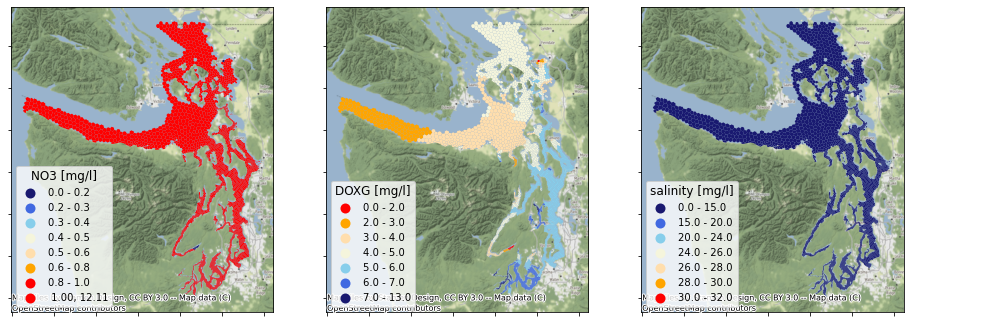

In [29]:
mpl.rc('font', size=10)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('legend', fontsize=10)
mpl.rc('axes', titlesize=14)
mpl.rc('axes', labelsize=10)
mpl.rc('figure', titlesize=10)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

fig, axs = plt.subplots(1,3, figsize = (16,30))
for idx,var in enumerate(model_var):
    gdf.plot(ax=axs[idx],
            column=var,
            scheme="User_Defined", 
            legend=True, 
            classification_kwds=dict(bins=upper_bounds[var]),
            cmap=mpl.colors.ListedColormap(color_list[var])
            )

    # remove x-, y-labels
    axs[idx].set_xticklabels('')
    axs[idx].set_yticklabels('')
    # set legend to lower left corner (instead of default upper-right, which overlaps SOGNB)
    legend = axs[idx].get_legend()
    legend._loc = 3 # lower-left
    legend.set_title(f'{var} [mg/l]')
    # # get all the legend labels
    # legend_labels = axs.get_legend().get_texts()
    # Change legend label format from 0.00, 2.00 to 0-2
    # get and format all bounds
    bounds=[]
    for index, upper_bound in enumerate(upper_bounds[var]):
        if index == 0:
            lower_bound = 0
        else:
            lower_bound = upper_bounds[var][index-1]
        print(lower_bound, upper_bound)

        # format the numerical legend here
        bound = f'{lower_bound:.1f} - {upper_bound:.1f}'
        bounds.append(bound)
    # get all the legend labels
    legend_labels = axs[idx].get_legend().get_texts()
    # replace the legend labels
    for bound, legend_label in zip(bounds, legend_labels):
        legend_label.set_text(bound)
    # # replace the legend labels
    # for bound, legend_label in zip(bounds, legend_labels):
    #     legend_label.set_text(bound)
    # Add land topography
    cx.add_basemap(axs[idx], 
        crs=gdf.crs
    )

    # cx.add_basemap(
    #     axs,
    #     crs=gdf.crs,
    #     source=cx.providers.Stamen.TerrainLabels, 
    #     zoom=10)
    #axs[idx].set_title(f'Maximum Daily NO3\nDay {day} of 2014')

In [22]:
for ind in range(len(legend_labels)):
    print(legend_labels[ind])

Text(0, 0, '0.0 - 0.2')
Text(0, 0, '0.2 - 0.3')
Text(0, 0, '0.3 - 0.4')
Text(0, 0, '0.4 - 0.5')
Text(0, 0, '0.5 - 0.6')
Text(0, 0, '0.6 - 0.8')
Text(0, 0, '0.8 - 1.0')


In [37]:
ssm['paths']['processed_output']

'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/'

In [ ]:
axs.get_legend().get_texts()[0]

In [ ]:
# get and format all bounds
bounds = []
upper_bounds=[2,3,4,5,6,7,12.11]
for index, upper_bound in enumerate(upper_bounds):
    if index == 0:
        lower_bound = 0
    else:
        lower_bound = upper_bounds[index-1]
    print(lower_bound, upper_bound)
    
    # format the numerical legend here
    bound = f'{lower_bound:.0f} - {upper_bound:.0f}'
    bounds.append(bound)

# get all the legend labels
legend_labels = axs.get_legend().get_texts()

# replace the legend labels
for bound, legend_label in zip(bounds, legend_labels):
    legend_label.set_text(bound)